# Experiment XMI Labels Clean
> Can we get better by training on our assumptions?

In [ ]:
# default_exp experiment_cifar10_xmi_labels_clean

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass, field
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch import nn
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
import batchbald_redux.acquisition_functions.bald
import batchbald_redux.acquisition_functions.coreset
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate
from batchbald_redux.dataset_operations import (
    get_base_dataset_index,
    get_target, AdditiveGaussianNoise, AliasDataset, get_balanced_sample_indices_by_class,
)
from batchbald_redux.datasets import get_dataset
from batchbald_redux.di import DependencyInjection
from batchbald_redux.resnet_models import Cifar10BayesianResnetFactory
from batchbald_redux.resnet_models import Cifar10ModelTrainer
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import ModelTrainer

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/cifar10_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

FileNotFoundError: [Errno 2] No such file or directory: './data/cifar10_train_predictions.pt'

In [ ]:
from matplotlib import pyplot as plt

(array([41483.,  2997.,   840.,   396.,   284.,   227.,   176.,   159.,
          150.,   117.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <BarContainer object of 10 artists>)

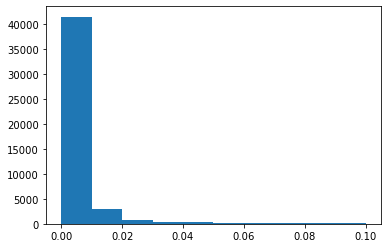

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.1])

In [ ]:
# exports

@dataclass
class ExperimentData:
    active_learning: ActiveLearningData
    train_dataset: Dataset
    train_augmentations: nn.Module
    validation_dataset: Dataset
    test_dataset: Dataset
    evaluation_dataset: Dataset
    initial_training_set_indices: [int]
    evaluation_set_indices: [int]


@dataclass
class ExperimentDataConfig:
    id_dataset_name: str
    initial_training_set_size: int
    validation_set_size: int
    evaluation_set_size: int
    id_repetitions: float
    add_dataset_noise: bool
    validation_split_random_state: int

    device: str

    def load(self) -> ExperimentData:
        return load_experiment_data(
            id_dataset_name=self.id_dataset_name,
            initial_training_set_size=self.initial_training_set_size,
            validation_set_size=self.validation_set_size,
            evaluation_set_size=self.evaluation_set_size,
            id_repetitions=self.id_repetitions,
            add_dataset_noise=self.add_dataset_noise,
            validation_split_random_state=self.validation_split_random_state,
            device=self.device,
        )


def load_experiment_data(
    *,
    id_dataset_name: str,
    initial_training_set_size: int,
    validation_set_size: int,
    evaluation_set_size: int,
    id_repetitions: float,
    add_dataset_noise: bool,
    validation_split_random_state: int,
    device: str,
) -> ExperimentData:
    split_dataset = get_dataset(id_dataset_name, root="data", validation_set_size=validation_set_size,
                                validation_split_random_state=validation_split_random_state, normalize_like_cifar10=True)

    assert id_dataset_name == "CIFAR-10"
    train_predictions = torch.load("./data/cifar10_train_predictions.pt", map_location=device)

    train_dataset = split_dataset.train
    train_indices = train_dataset.dataset.indices
    train_dataset = train_dataset.override_targets(targets=train_predictions[train_indices].argmax(dim=1))

    train_entropies = compute_entropy_from_probs(train_predictions[train_indices, None, :])

    entropy_threshold = 0.01
    allowed_indices = torch.nonzero(train_entropies < entropy_threshold, as_tuple=True)[0].numpy()
    print(f"Removing {len(train_dataset) - len(allowed_indices)} training samples with entropy >= {entropy_threshold}.")

    train_dataset = train_dataset.subset(allowed_indices)

    # If we reduce the train set, we need to do so before picking the initial train set.
    if id_repetitions < 1:
        train_dataset = train_dataset * id_repetitions

    targets = train_dataset.get_targets()
    num_classes = train_dataset.get_num_classes()
    initial_samples_per_class = initial_training_set_size // num_classes
    evaluation_set_samples_per_class = evaluation_set_size // num_classes
    samples_per_class = initial_samples_per_class + evaluation_set_samples_per_class
    balanced_samples_indices = get_balanced_sample_indices_by_class(
        targets=targets,
        num_classes=num_classes,
        samples_per_class=samples_per_class,
        seed=validation_split_random_state,
    )

    initial_training_set_indices = [
        idx for by_class in balanced_samples_indices.values() for idx in by_class[:initial_samples_per_class]
    ]
    evaluation_set_indices = [
        idx for by_class in balanced_samples_indices.values() for idx in by_class[initial_samples_per_class:]
    ]

    # If we over-sample the train set, we do so after picking the initial train set to avoid duplicates.
    if id_repetitions > 1:
        train_dataset = train_dataset * id_repetitions

    if add_dataset_noise:
        train_dataset = AdditiveGaussianNoise(train_dataset, 0.1)

    active_learning_data = ActiveLearningData(train_dataset)

    active_learning_data.acquire_base_indices(initial_training_set_indices)

    evaluation_dataset = AliasDataset(
        active_learning_data.extract_dataset_from_base_indices(evaluation_set_indices),
        f"Evaluation Set ({len(evaluation_set_indices)} samples)",
    )

    return ExperimentData(
        active_learning=active_learning_data,
        train_dataset=train_dataset,
        # NO AUGMENTATIONS!
        train_augmentations=None,
        validation_dataset=split_dataset.validation,
        test_dataset=split_dataset.test,
        evaluation_dataset=evaluation_dataset,
        initial_training_set_indices=initial_training_set_indices,
        evaluation_set_indices=evaluation_set_indices,
    )

In [ ]:
# exports

@dataclass
class Experiment:
    seed: int

    id_dataset_name: str = "CIFAR-10"
    initial_training_set_size: int = 1000
    validation_set_size: int = 5000
    evaluation_set_size: int = 0
    id_repetitions: float = 1
    add_dataset_noise: bool = False
    validation_split_random_state: int = 0

    acquisition_size: int = 5
    max_training_set: int = 300
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    max_training_epochs: int = 120
    training_batch_size: int = 128
    device: str = "cuda"
    min_samples_per_epoch: int = 5056
    patience_schedule: [int] = (6, 4, 3)
    factor_schedule: [int] = (0.1,)
    acquisition_function: Union[
        Type[CandidateBatchComputer], Type[EvalModelBatchComputer]
    ] = batchbald_redux.acquisition_functions.bald.BALD
    train_eval_model: Type[TrainEvalModel] = TrainSelfDistillationEvalModel
    model_trainer_factory: Type[ModelTrainer] = Cifar10ModelTrainer
    acquisition_function_args: dict = None
    temperature: float = 0.0
    prefer_accuracy: bool = True

    def load_experiment_data(self) -> ExperimentData:
        di = DependencyInjection(vars(self))
        edc: ExperimentDataConfig = di.create_dataclass_type(ExperimentDataConfig)
        return edc.load()

    # Simple Dependency Injection
    def create_acquisition_function(self):
        di = DependencyInjection(vars(self))
        return di.create_dataclass_type(self.acquisition_function)

    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def create_model_trainer(self) -> ModelTrainer:
        di = DependencyInjection(vars(self))
        return di.create_dataclass_type(self.model_trainer_factory)

    def run(self, store):
        torch.manual_seed(self.seed)

        # Active Learning setup
        data = self.load_experiment_data()
        store["dataset_info"] = dict(training=repr(data.active_learning.base_dataset), test=repr(data.test_dataset))
        store["initial_training_set_indices"] = data.initial_training_set_indices
        store["evaluation_set_indices"] = data.evaluation_set_indices

        train_loader = torch.utils.data.DataLoader(
            data.active_learning.training_dataset,
            batch_size=self.training_batch_size,
            sampler=RandomFixedLengthSampler(data.active_learning.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )
        pool_loader = torch.utils.data.DataLoader(
            data.active_learning.pool_dataset, batch_size=128, drop_last=False, shuffle=False
        )

        validation_loader = torch.utils.data.DataLoader(data.validation_dataset, batch_size=512, drop_last=False)
        test_loader = torch.utils.data.DataLoader(data.test_dataset, batch_size=512, drop_last=False)

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        acquisition_function = self.create_acquisition_function()
        model_trainer = self.create_model_trainer()

        loss = validation_loss = torch.nn.NLLLoss()

        # Active Training Loop
        while True:
            training_set_size = len(data.active_learning.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            trained_model = model_trainer.get_trained(train_loader=train_loader,
                                                      train_augmentations=data.train_augmentations,
                                                      validation_loader=validation_loader,
                                                      log=iteration_log["training"], loss=loss,
                                                      validation_loss=validation_loss)

            evaluation_metrics = evaluate(model=trained_model, num_samples=self.num_validation_samples,
                                          loader=test_loader, device=self.device, storage_device="cpu")

            iteration_log["evaluation_metrics"] = evaluation_metrics
            print(f"Perf after training {evaluation_metrics}")

            if training_set_size >= self.max_training_set:
                print("Done.")
                break

            if isinstance(acquisition_function, CandidateBatchComputer):
                candidate_batch = acquisition_function.compute_candidate_batch(trained_model, pool_loader, self.device)
            else:
                raise ValueError(f"Unknown acquisition function {acquisition_function}!")

            candidate_global_indices = [
                get_base_dataset_index(data.active_learning.pool_dataset, index).index
                for index in candidate_batch.indices
            ]
            candidate_labels = [
                get_target(data.active_learning.pool_dataset, index).item() for index in candidate_batch.indices
            ]

            iteration_log["acquisition"] = dict(
                indices=candidate_global_indices, labels=candidate_labels, scores=candidate_batch.scores
            )

            data.active_learning.acquire(candidate_batch.indices)

            ls = ", ".join(f"{label} ({score:.4})" for label, score in zip(candidate_labels, candidate_batch.scores))
            print(f"Acquiring (label, score)s: {ls}")

In [ ]:
# experiment

experiment = Experiment(
    seed=1120,
    max_training_epochs=1,
    max_training_set=20005,
    acquisition_function=acquisition_functions.BatchCoreSetBALD,
    acquisition_size=5,
    num_pool_samples=20,
    initial_training_set_size=20000,
    temperature=8,
    min_samples_per_epoch=5000,
    device="cuda",
)

results = {}
experiment.run(results)

Creating: ExperimentDataConfig(
	id_dataset_name=CIFAR-10,
	initial_training_set_size=20000,
	validation_set_size=5000,
	evaluation_set_size=0,
	id_repetitions=1,
	add_dataset_noise=False,
	validation_split_random_state=0,
	device=cuda
)
Files already downloaded and verified


/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the pre

Files already downloaded and verified


Entropy:   0%|          | 0/45000 [00:00<?, ?it/s]

Removing 7623 training samples with entropy >= 0.01.
Creating: BatchCoreSetBALD(
	acquisition_size=5,
	num_pool_samples=20
)
Creating: Cifar10ModelTrainer(
	device=cuda,
	num_training_samples=1,
	num_validation_samples=20,
	max_training_epochs=1,
	patience_schedule=(6, 4, 3),
	factor_schedule=(0.1,),
	min_samples_per_epoch=5000
)
Training set size 20000:
Cosine Annealing


100%|##########| 1/1 [00:00<?, ?it/s]

[1/156]   1%|           [00:00<?]

[1/10]  10%|#          [00:00<?]

Epoch 1 metrics: {'accuracy': 0.3344, 'crossentropy': 1.7623895263671876}


get_predictions_labels:   0%|          | 0/200000 [00:00<?, ?it/s]

Perf after training {'accuracy': 0.3408, 'crossentropy': tensor(1.7030)}


get_predictions_labels:   0%|          | 0/347540 [00:00<?, ?it/s]

BatchCoreSetBALD:   0%|          | 0/5 [00:00<?, ?it/s]

Acquiring (label, score)s: 3 (1.029), 5 (2.093), 5 (2.698), 3 (2.903), 3 (2.966)
Training set size 20005:
Cosine Annealing


100%|##########| 1/1 [00:00<?, ?it/s]

[1/156]   1%|           [00:00<?]

[1/10]  10%|#          [00:00<?]

Epoch 1 metrics: {'accuracy': 0.3298, 'crossentropy': 1.7995323238372802}


get_predictions_labels:   0%|          | 0/200000 [00:00<?, ?it/s]

Perf after training {'accuracy': 0.3295, 'crossentropy': tensor(1.7435)}
Done.


In [ ]:
results

{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'dataset_info': {'training': "'FastMNIST (Train)'",
  'test': "'FastMNIST (Test)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.62109375,
      'crossentropy': 2.6530187726020813},
     {'accuracy': 0.6376953125, 'crossentropy': 2.762658029794693},
     {'accuracy': 0.646484375, 'crossentropy': 3.056214064359665},
     {'accuracy': 0.6416015625, 'crossentropy': 3.1257119178771973}],
    'best_epoch': 1},
   'evaluation_metrics': {'accuracy': 0.631,
    'crossentropy': 2.6251225173950195}}]}

In [ ]:
# experiment

experiment = Experiment(
    max_training_epochs=1, max_training_set=25, acquisition_function=AcquisitionFunction.randombaldical
)

results = {}
experiment.run(results)

results

Training set size 20:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -6.529030114412308)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.5367, 'crossentropy': 6.438035237884521}


get_predictions:   0%|          | 0/463616 [00:00<?, ?it/s]

100%|##########| 1/1 [00:00<?, ?it/s]

[1/1811]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -5.1637596152722836)
RestoringEarlyStopping: Restoring optimizer.


get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Acquiring (label, score)s: 8 (0.8711), 8 (0.8687), 3 (0.876), 3 (0.8465), 3 (0.8811)
Training set size 25:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -4.6851686127483845)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.6256, 'crossentropy': 4.484497045135498}
Done.


{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.538818359375,
      'crossentropy': 6.529030114412308}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.5367,
    'crossentropy': 6.438035237884521},
   'pool_training': {'epochs': [{'accuracy': 0.531005859375,
      'crossentropy': 5.1637596152722836}],
    'best_epoch': 1},
   'acquisition': {'indices': [63338, 10856, 63452, 81864, 109287],
    'labels': [8, 8, 3, 3, 3],
    'scores': [0.8710822958846325,
     0.8687216999221631,
     0.8759664372823723,
     0.8464646732511746,
     0.8810812784952251]}},
  {'training': {'epochs': [{'accuracy': 0.62255859375,
      'crossentropy': 4.6851686127483845}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.6256,
    'crossentropy': 4.4844970451

In [ ]:
# FIRST EXPERIMENT SET

configs = [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_function,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        temperature=8,
    )
    for seed in range(5)
    for acquisition_function in [
        acquisition_functions.BALD,
        acquisition_functions.CoreSetBALD,
    ]
    for acquisition_size in [1]
    for num_pool_samples in [100]
] + [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_functions.Random,
        acquisition_size=5,
        num_pool_samples=1,
    )
    for seed in range(5)
]

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed + 7777,
        acquisition_function=acquisition_function,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        initial_training_set_size=0,
        max_training_set=250,
        prefer_accuracy=True
    )
    for seed in range(5)
    for acquisition_function in [
        batchbald_redux.acquisition_functions.coreset.CoreSetBALD,
        batchbald_redux.acquisition_functions.bald.BALD,
        #acquisition_functions.Random,
    ]
    for acquisition_size in [1]
    for num_pool_samples in [100]
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

10

In [ ]:
import prettyprinter
prettyprinter.install_extras({"dataclasses"})
prettyprinter.pprint(configs)

[
    Experiment(
        seed=7777,
        initial_training_set_size=0,
        acquisition_size=1,
        max_training_set=250,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.CoreSetBALD
    ),
    Experiment(
        seed=7777,
        initial_training_set_size=0,
        acquisition_size=1,
        max_training_set=250,
        num_pool_samples=100
    ),
    Experiment(
        seed=7778,
        initial_training_set_size=0,
        acquisition_size=1,
        max_training_set=250,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.CoreSetBALD
    ),
    Experiment(
        seed=7778,
        initial_training_set_size=0,
        acquisition_size=1,
        max_training_set=250,
        num_pool_samples=100
    ),
    Experiment(
        seed=7779,
        initial_training_set_size=0,
        acquisition_size=1,
        max_training_set=250,
        num_